<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Spam/Ham Classification Project Pt. 1

## Feature Engineering, Logistic Regression

<br/>

<hr style="border: 1px solid #fdb515;" />

## This Project
In this project, I will create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. The structure of this project and the raw data was provided by Josh Hug and Lisa Yan,the instructors of the Data100 class at UC Berkeley, Spring 2022.

This project enforces the following concepts:

- Feature engineering with text data
- Using `sklearn` libraries to process data and fit models
- Validating the performance of a model and minimizing overfitting
- Generating and analyzing precision-recall curves

In [42]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.
The iwut extension is already loaded. To reload it, use:
  %reload_ext iwut


<br/>

<hr style="border: 1px solid #fdb515;" />

## Initial Analysis

In [43]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset is from [SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/). It consists of email messages and their labels (0 for ham, 1 for spam). The training dataset is labeled and contains 8348 labeled examples.

Note: The dataset is from 2004, so the contents of emails might be very different from those in 2022.

Run the following cells to load the data into DataFrames.

The `train` DataFrame contains labeled data that I will use to train the model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

In [44]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [45]:
original_training_data = pd.read_csv('train.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


First, let's check if the data contains any missing values. We have filled in the cell below to print the number of NaN values in each column. If there are NaN values, I will replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns will be replaced with empty strings). Finally, I will print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, care must be taken when replacing NaN labels. Doing so without consideration may introduce significant bias into the model when fitting.

In [46]:
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


### A look at the data

In the cell below, we have printed the text of the `email` field for the first ham and the first spam email in the original training set.

In [47]:
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



The most obvious thing is that in the spam email, there are a lot of pointy brackets with things like like "head" and "body", which is pretty suspicious.

<br/>

<hr style="border: 1px solid #fdb515;" />

## Training-Validation Split
The training data is all the data we have available for both training models and **validating** the models that we train.  So I need to split the training data into separate training and validation datsets.  This **validation data** is needed to assess the performance of the trained classifier model. Note that the seed (`random_state`) is set to 42. This will produce a pseudo-random sequence of random numbers that is the same every time.

In [48]:
# This creates a 90/10 train-validation split on our labeled data

from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

<br/>

<hr style="border: 1px solid #fdb515;" />

## Basic Feature Engineering

I want to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so I can use logistic regression to train a classifier. To train a logistic regression model, I need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$.  Unfortunately, the data are text, not numbers. To address this, I can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is an email. Each column of $X$ contains one feature for all the emails.

Here, I will create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It will output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```


<!--
BEGIN QUESTION
name: q2
points: 3
-->

In [49]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = np.transpose([texts.str.contains(word).astype('int').to_numpy() for word in words])
    return indicator_array

words_in_texts(['a', 'b', 'c', 'd', 'e', 'f', 'g'], pd.Series(['a b c d ef g', 'a', 'b', 'c', 'd e f g', 'h', 'a h']))

array([[1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]])

<br/>

<hr style="border: 1px solid #fdb515;" />

# Basic EDA

I need to identify some features that allow me to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


Below, I will create a bar chart comparing the proportion of spam and ham emails containing certain words (only considering emails from the `train` set).

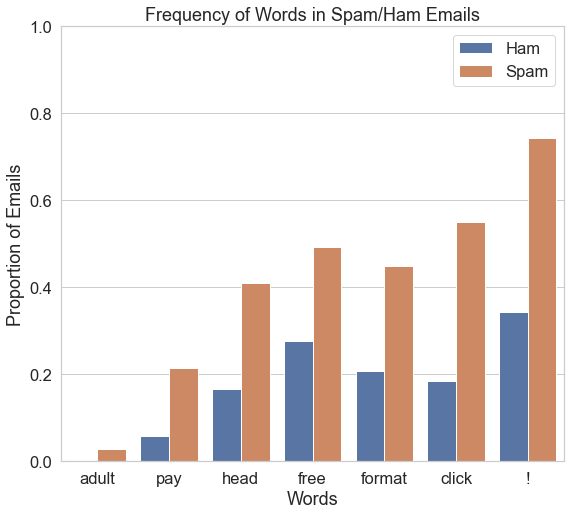

In [50]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts

words =['adult', 'pay', 'head', 'free', 'format', 'click', '!']
df = train.copy().join(pd.DataFrame(data=words_in_texts(words, train['email']), columns=words)).drop(['id', 'subject', 'email'], axis=1)
melted = df.melt('spam')
melted['spam'] = melted['spam'].map({0:'Ham', 1:'Spam'})

plt.figure(figsize=(9, 8))
sns.barplot(data=melted, x='variable', y='value', hue='spam', ci=None)
plt.ylim(0,1)
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.title('Frequency of Words in Spam/Ham Emails')
plt.gca().legend().set_title('')


When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, the distributions of these values for different classes can be compared. 

<br/>

<hr style="border: 1px solid #fdb515;" />

## Basic Classification

Since the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email, I can use it directly to train a logistic regression model.

5 words that might be useful as features to distinguish spam/ham emails are ['drug', 'bank', 'prescription', 'memo', 'private']. I will use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

`X_train` will be a matrix of 0s and 1s created by using the `words_in_texts` function on all the emails in the training set.

`Y_train` will be a vector of the correct labels for each email in the training set.


In [51]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = train['spam']

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

Now that I have matrices, I can build a model with `scikit-learn`. Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, I will train a logistic regression model using `X_train` and `Y_train`. Then, I will output the model's training accuracy below.

In [52]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=True, solver='lbfgs')
model.fit(X_train, Y_train)
yHat_train = model.predict(X_train)

training_accuracy = np.mean(yHat_train == Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


<br/>

<hr style="border: 1px solid #fdb515;" />

## Evaluating Classifiers

An accuracy of almost 76% seems pretty good, but the classifier above isn't as good as this number makes it seem. First, I am evaluating accuracy on the training set, which may provide a misleading accuracy measure. Accuracy on the training set doesn't always translate to accuracy in the real world (on the validation set). In future parts of this analysis, the model's performance will be evaluated on the validation data.

Presumably, the classifier will be used for **filtering** 'spam' messages out of an inbox. There are two kinds of errors that can be made:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

To be clear, spam emails are labeled as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance; there are more ways of evaluating a classifier in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

Suppose there is a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? The code below outputs the answer to this question.

In [53]:
zero_predictor_fp = 0
zero_predictor_fn = sum(Y_train)
zero_predictor_fp, zero_predictor_fn

(0, 1918)

What is the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Again, the code below outputs the answer.

In [54]:
zero_predictor_acc = np.mean(0 == Y_train)
zero_predictor_recall = 0
zero_predictor_acc, zero_predictor_recall

(0.7447091707706642, 0)

Since this model always predicts that an email is ham, the number of false positives is 0 as is the number of true positives; it never flags anything as positive. Inversely, the number of false negatives is equal to the number of actual positives in the training data, since they are all flagged as ham when in fact they are spam. Because the number of true positives is 0, the precision and recall of this model are also 0. The accuracy of this zero model is the sum of the number of true negatives over the number of emails, since the model never predicts true positives.

### Precision, Recall, and False-alarm Rate

What's the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained above?

In [55]:
logistic_predictor_precision = sum((yHat_train == Y_train) & (yHat_train == 1))/sum(yHat_train)
logistic_predictor_recall = sum((yHat_train == Y_train) & (yHat_train == 1))/sum(Y_train)
logistic_predictor_far = sum((yHat_train != Y_train) & (yHat_train == 1))/sum(1-Y_train)

With this Logistic Regression classifier, there are far more false negatives than there are false positives.

This logistic regression classifier had only a slightly higher accuracy rate than the 'zero-model', which had an accuracy of 74.47%; as it turns out, none of the words included in the model are very prevalent in the ham or spam emails, which could be one reason that the model is performing poorly.


<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Spam/Ham Classification Project Pt. 2

## Feature Engineering, Classification, Cross Validation

In this part of the project, I will build and improve on the concepts and functions implemented in part 1 to create a better classifier model to distinguish spam emails from ham (non-spam) emails.

This part of the project enforces the following concepts:

- Using `sklearn` libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves


## Warning
This is a **real world** dataset – the emails to be classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate.

In [56]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

<br/>

<hr style="border: 1px solid #fdb515;" />

## Setup and Recap

Below is a summary of the data cleaning, data exploration, and feature engineering.

### Loading and Cleaning Data

The dataset consists of email messages and their labels (0 for ham, 1 for spam).

The `train` DataFrame contains four columns:

1. `id`: An identifier for the training example
2. `subject`: The subject of the email
3. `email`: The text of the email
4. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

To preprocess this data, I converted all the text to lowercase and filled NA values.

### Training/Validation Split

I split the training data into separate training and validation datsets (with a set random seed for reproduceable results) to assess the performance of the classifier model once training is complete.

### Feature Engineering

In order to train a logistic regression model, I need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$. Above, I used the function `words_in_texts` to get a numeric feature matrix from the email text. By changing the words considered in the model and adding some other features columns to the output of the `words_in_texts` function, I can improve the classifier model's accuracy. In this project, I'm shooting for an accuracy of **88%** or higher using only a logistic regression model (no decision trees, random forests, k-nearest-neighbors, neural nets, etc).

<br/>

<hr style="border: 1px solid #fdb515;" />

## Choosing New Features
I want to take a look at the comparative frequency of a few more words in spam/ham emails. The 2 cells below graph the proportional frequencies of a list of each word in a list I created.

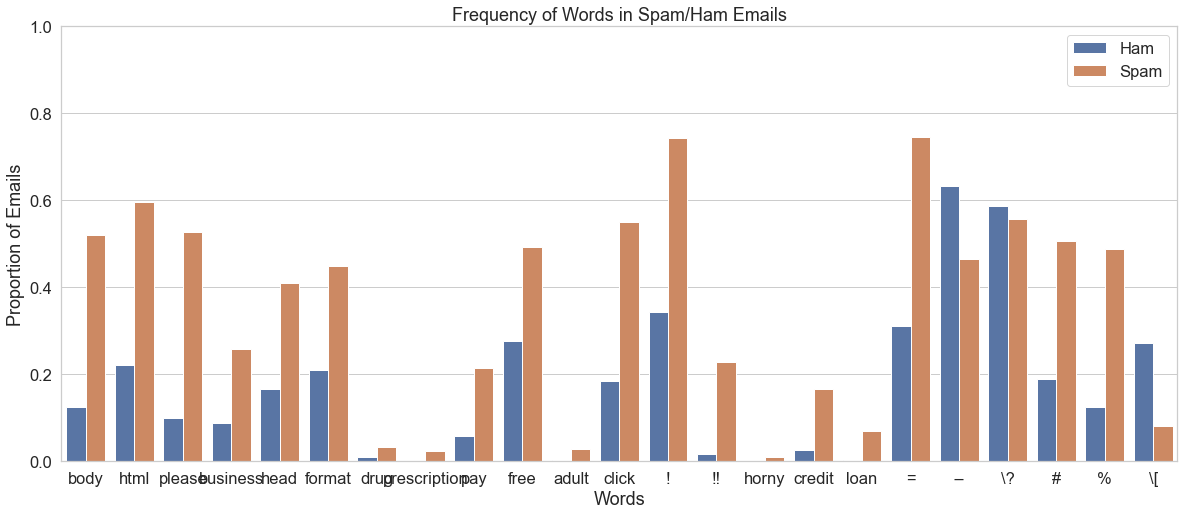

In [57]:
e_words =['body', 'html', 'please', 'business', 'head', 'format', 'drug', 'prescription', 'pay', 'free', 'adult', 'click',
        '!', '!!', 'horny', 'credit', 'loan', '=', '--', '\?', '#', '%', '\[']
df = train.copy().join(pd.DataFrame(data=words_in_texts(e_words, train['email']), columns=e_words)).drop(['id', 'subject', 'email'], axis=1)
melted = df.melt('spam')
melted['spam'] = melted['spam'].map({0:'Ham', 1:'Spam'})

plt.figure(figsize=(20, 8))
sns.barplot(data=melted, x='variable', y='value', hue='spam', ci=None)
plt.ylim(0,1)
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.title('Frequency of Words in Spam/Ham Emails')
plt.gca().legend().set_title('')

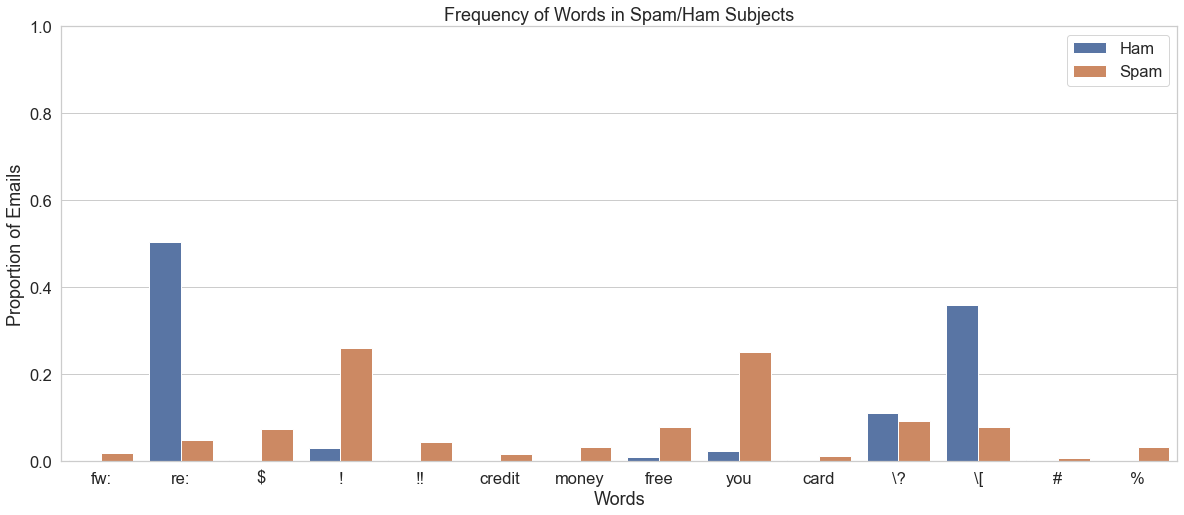

In [58]:
s_words = ['fw:', 're:', '\$', '!','!!', 'credit', 'money', 'free', 'you', 'card', 'free', '\?', '\[', '#', '%']
df = train.copy().join(pd.DataFrame(data=words_in_texts(s_words, train['subject'].str.lower()), columns=s_words)).drop(['id', 'subject', 'email'], axis=1)
melted = df.melt('spam')
melted['spam'] = melted['spam'].map({0:'Ham', 1:'Spam'})

plt.figure(figsize=(20, 8))
sns.barplot(data=melted, x='variable', y='value', hue='spam', ci=None)
plt.ylim(0,1)
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.title('Frequency of Words in Spam/Ham Subjects')
plt.gca().legend().set_title('')

In the code below, I will define some helper functions to add some more numerical features to the feature matrix.

In [59]:
# In this chunk I'm defining helper function that add features to the matrix
from sklearn import preprocessing

def add_length_chars(data, col):
    copy = data.copy()
    copy[col + ' length chars'] = copy[col].str.len()
    return copy

def add_length_words(data, col):
    copy = data.copy()
    copy[col + ' length words'] = copy[col].str.split().str.len()
    return copy

def add_prop_length_chars(data):
    copy = data.copy()
    e_length = copy['email'].str.len()
    s_length = copy['subject'].str.len()
    copy['prop length'] = s_length/e_length
    return copy

def add_prop_length_words(data):
    copy = data.copy()
    e_length = copy['email'].str.split().str.len()
    s_length = copy['subject'].str.split().str.len()
    copy['prop length'] = s_length/e_length
    return copy

def add_num_caps(data, column):
    copy = data.copy()
    copy['num caps in ' + column] = copy[column].str.count(r'[A-Z]')
    return copy

def add_longest_caps(data, column):
    copy = data.copy()
    copy['longest caps in ' + column] = copy[column].str.findall(r'[A-Z]+').apply(len)
    return copy

def numbers(data, column):
    copy = data.copy()
    copy['numbers in ' + column] = copy[column].str.count(r'[0-9]+')
    return copy




def scale(data, columns):
    copy = data.copy()
    for col in columns:
        copy[col] = (copy[col] - np.mean(copy[col]))/np.std(copy[col])
        #copy = copy.rename({col:' (scaled)'}, inplace=True)
    return copy
        
        
        
def drop_cols(df, cols):
    for col in cols:
        df.drop(col)

With these helper functions defined, I can create some visualizations to check whether these might make good features before I put them in the model. The following three cells will draw a total of nine histograms, each comparing the distribution of a feature across spam and ham emails.

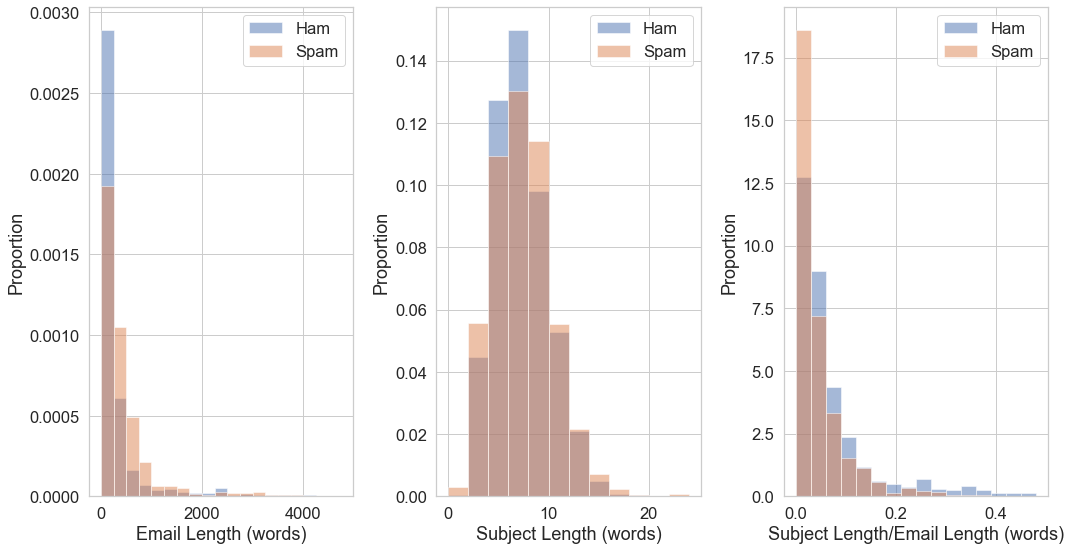

In [60]:
ham_e_lengths_w = add_length_words(train[train['spam']==0], 'email').iloc[:, -1]
spam_e_lengths_w = add_length_words(train[train['spam']==1], 'email').iloc[:, -1]

ham_s_lengths_w = add_length_words(train[train['spam']==0], 'subject').iloc[:, -1]
spam_s_lengths_w = add_length_words(train[train['spam']==1], 'subject').iloc[:, -1]

ham_prop_lengths_words = add_prop_length_words(train[train['spam']==0]).iloc[:, -1]
spam_prop_lengths_words = add_prop_length_words(train[train['spam']==1]).iloc[:, -1]

f1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8)) 

e_bins = np.arange(0, 5000, 250)
s_bins = np.arange(0, 25, 2)
p_bins = np.arange(0, 0.5, 0.03)

ax1.hist(ham_e_lengths_w, bins=e_bins, density=True, alpha=0.5, label='Ham')
ax1.hist(spam_e_lengths_w, bins=e_bins, density=True, alpha=0.5, label='Spam')
ax1.set_xlabel('Email Length (words)')
ax1.set_ylabel('Proportion')
ax1.legend()

ax2.hist(ham_s_lengths_w, bins=s_bins, density=True, alpha=0.5, label='Ham')
ax2.hist(spam_s_lengths_w, bins=s_bins, density=True, alpha=0.5, label='Spam')
ax2.set_xlabel('Subject Length (words)')
ax2.set_ylabel('Proportion')
ax2.legend()

ax3.hist(ham_prop_lengths_words, bins=p_bins, density=True, alpha=0.5, label='Ham')
ax3.hist(spam_prop_lengths_words, bins=p_bins, density=True, alpha=0.5, label='Spam')
ax3.set_xlabel('Subject Length/Email Length (words)')
ax3.set_ylabel('Proportion')
ax3.legend()

f1.tight_layout()

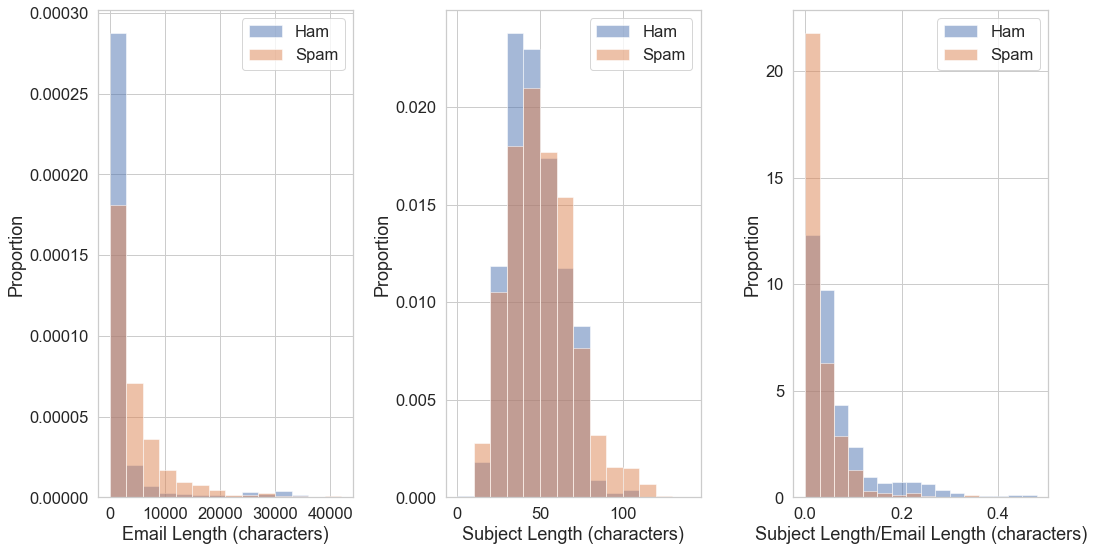

In [61]:
ham_e_lengths = add_length_chars(train[train['spam']==0], 'email').iloc[:, -1]
spam_e_lengths = add_length_chars(train[train['spam']==1], 'email').iloc[:, -1]

ham_s_lengths = add_length_chars(train[train['spam']==0], 'subject').iloc[:, -1]
spam_s_lengths = add_length_chars(train[train['spam']==1], 'subject').iloc[:, -1]

ham_prop_lengths_chars = add_prop_length_chars(train[train['spam']==0]).iloc[:, -1]
spam_prop_lengths_chars = add_prop_length_chars(train[train['spam']==1]).iloc[:, -1]

e_bins = np.arange(0, 45000, 3000)
s_bins = np.arange(0, 150, 10)
p_bins = np.arange(0, 0.5, 0.03)


f2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8)) 


ax1.hist(ham_e_lengths, bins=e_bins, density=True, alpha=0.5, label='Ham')
ax1.hist(spam_e_lengths, bins=e_bins, density=True, alpha=0.5, label='Spam')
ax1.set_xlabel('Email Length (characters)')
ax1.set_ylabel('Proportion')
ax1.legend()

ax2.hist(ham_s_lengths, bins=s_bins, density=True, alpha=0.5, label='Ham')
ax2.hist(spam_s_lengths, bins=s_bins, density=True, alpha=0.5, label='Spam')
ax2.set_xlabel('Subject Length (characters)')
ax2.set_ylabel('Proportion')
ax2.legend()

ax3.hist(ham_prop_lengths_chars, bins=p_bins, density=True, alpha=0.5, label='Ham')
ax3.hist(spam_prop_lengths_chars, bins=p_bins, density=True, alpha=0.5, label='Spam')
ax3.set_xlabel('Subject Length/Email Length (characters)')
ax3.set_ylabel('Proportion')
ax3.legend()

f2.tight_layout()

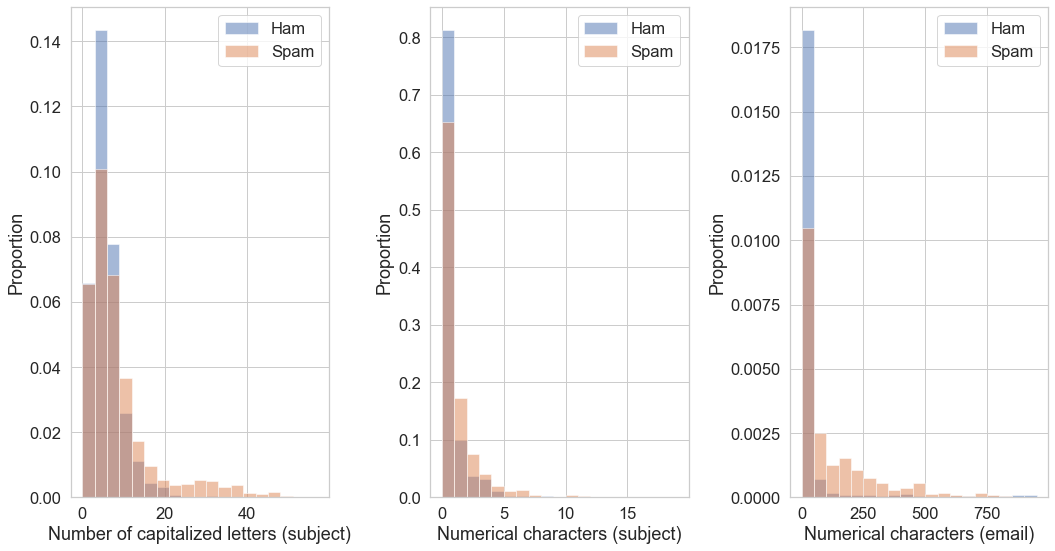

In [62]:
ham_num_caps = add_num_caps(train[train['spam']==0], 'subject').iloc[:, -1]
spam_num_caps = add_num_caps(train[train['spam']==1], 'subject').iloc[:, -1]

ham_s_numbers = numbers(train[train['spam']==0], 'subject').iloc[:, -1]
spam_s_numbers = numbers(train[train['spam']==1], 'subject').iloc[:, -1]

ham_e_numbers = numbers(train[train['spam']==0], 'email').iloc[:, -1]
spam_e_numbers = numbers(train[train['spam']==1], 'email').iloc[:, -1]

caps_bins = np.arange(0, 60, 3)
num_s_bins = np.arange(0, 20, 1)
num_e_bins = np.arange(0, 1000, 50)

f3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8)) 

ax1.hist(ham_num_caps, bins=caps_bins, density=True, alpha=0.5, label='Ham')
ax1.hist(spam_num_caps, bins=caps_bins, density=True, alpha=0.5, label='Spam')
ax1.set_xlabel('Number of capitalized letters (subject)')
ax1.set_ylabel('Proportion')
ax1.legend()

ax2.hist(ham_s_numbers, bins=num_s_bins, density=True, alpha=0.5, label='Ham')
ax2.hist(spam_s_numbers, bins=num_s_bins, density=True, alpha=0.5, label='Spam')
ax2.set_xlabel('Numerical characters (subject)')
ax2.set_ylabel('Proportion')
ax2.legend()

ax3.hist(ham_e_numbers, bins=num_e_bins, density=True, alpha=0.5, label='Ham')
ax3.hist(spam_e_numbers, bins=num_e_bins, density=True, alpha=0.5, label='Spam')
ax3.set_xlabel('Numerical characters (email)')
ax3.set_ylabel('Proportion')
ax3.legend()

f3.tight_layout()

The plots above eah overlay the distributions of a particular feature (email length, subject length, proportional length of subject v. email, number of capitalized letters in the subject, and the number of numerical characters in the subject and email respectively) among the ham and spam emails. From these visualizations, it's clear that most of these features have a significantly different distribution among ham/spam emails; namely, it looks like spam emails tend to be longer than ham emails, but tend to have a smaller ratio of subject to email length; additionally, spam emails tend to have relatively more capital characters in the subject and numerical characters (in the subject and email) than ham emails do. These differing distributions tell us that these features are likely helpful to the model and should be considered.

Looking at these, it seems as if there **is** a significant difference in the distributions of these features among spam and ham emails, so I will include them in the classification model.

<br/>

<hr style="border: 1px solid #fdb515;" />

## Building the Feature Matrix
This next chunk holds the lists of words I want to use as features in my model and defines the function `engineer`, which acts a pipeline taking in the data and applying the helper functions to output the fully engineered feature matrix.

In [63]:
email_words = ['body', 'html', 'please', 'business', 'head', 'format',
               'drug', 'prescription', 'pay', 'free', 'adult', 'click',
               '!', '!!', 'horny', 'credit', 'loan', '=', '--', '\?', '#', '%', '\[']

subject_words = ['fw:', 're:', '\$', '!','!!', 'credit', 'money', 'free', 'you', 'card', 'free', '\?', '\[']


def engineer(data):
    # Drop 'spam' from training data and fill NAs in testing data
    if 'spam' in data.columns:
        data = data.drop('spam', axis=1)
    else:
        data = data.fillna('')
        
    # Add features
    data = add_length_chars(data, 'email')
    data = add_length_chars(data, 'subject')
    data = add_length_words(data, 'email')
    data = add_length_words(data, 'subject')
    data = add_prop_length_chars(data)
    data = add_num_caps(data, 'subject')
    data = numbers(data, 'email')
    data = numbers(data, 'subject')
    ##data = add_length_chars(data, 'subject')
    ##data = add_longest_caps(data, 'subject')
    
    # Scale features
    data = scale(data, ['numbers in email'])
    data = scale(data, ['numbers in subject'])
    data = scale(data, ['email length chars'])
    data = scale(data, ['subject length chars'])
    data = scale(data, ['email length words'])
    data = scale(data, ['subject length words'])
    ##data = scale(data, ['prop length'])
    
    # Create binary word matrix, convert to df, and scale
    email_words = ['body', 'html', 'please', 'business', 'head', 'format',
               'drug', 'prescription', 'pay', 'free', 'adult', 'click',
               '!', '!!', 'horny', 'credit', 'loan', '=', '--', '\?', '#', '%', '\[']

    subject_words = ['fw:', 're:', '\$', '!','!!', 'credit', 'money', 'free', 'you', 'card', 'free', '\?', '\[']
    
    words_in_emails = pd.DataFrame(data=words_in_texts(email_words, data['email']), columns=email_words)
    words_in_subjects = pd.DataFrame(data=words_in_texts(subject_words, data['subject'].str.lower()), columns=subject_words)
    words_data = words_in_emails.join(words_in_subjects, lsuffix='_em', rsuffix='_sub')
    words_data = scale(words_data, words_data.columns)
    
    # Reset index to add word matrix
    data = data.copy().reset_index()
    
    # Drop unnecessary columns
    data = data.drop(['id', 'subject', 'email', 'index'], axis=1)
    
    # Join binary word matrix to the rest of the df
    data = words_data.join(data)
        
    return data

<br/>

<hr style="border: 1px solid #fdb515;" />

## Assessing and Optimizing the Model
By using the assess function below with a list of parameter values, I can look and see what value gives me the highest training and validation accuracy. This is how I will know what value I should use in my model.

In [64]:

def assess(train, val, C_list):
    for C in C_list:
        X_train, Y_train = engineer(train), train['spam']
        X_val, Y_val = engineer(val), val['spam']
        my_model = LogisticRegression(fit_intercept = True, solver = 'lbfgs', C=C)
        my_model.fit(X_train, Y_train)
        print('training accuracy w/ C= ' + str(C) + ': ' + str(my_model.score(X_train, Y_train)))
        print('validation accuracy w/ C= ' + str(C) + ': ' + str(my_model.score(X_val, Y_val)))


C_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
assess(train, val, C_list)

training accuracy w/ C= 0.1: 0.9361107413816052
validation accuracy w/ C= 0.1: 0.9305389221556887
training accuracy w/ C= 0.2: 0.9353121256488753
validation accuracy w/ C= 0.2: 0.9317365269461078


C:\Users\tobyk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training accuracy w/ C= 0.3: 0.935445228270997
validation accuracy w/ C= 0.3: 0.9305389221556887


C:\Users\tobyk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training accuracy w/ C= 0.4: 0.9355783308931186
validation accuracy w/ C= 0.4: 0.9293413173652695


C:\Users\tobyk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training accuracy w/ C= 0.5: 0.9353121256488753
validation accuracy w/ C= 0.5: 0.9317365269461078


C:\Users\tobyk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training accuracy w/ C= 0.6: 0.9353121256488753
validation accuracy w/ C= 0.6: 0.932934131736527


C:\Users\tobyk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training accuracy w/ C= 0.7: 0.9353121256488753
validation accuracy w/ C= 0.7: 0.932934131736527


C:\Users\tobyk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training accuracy w/ C= 0.8: 0.9357114335152402
validation accuracy w/ C= 0.8: 0.932934131736527
training accuracy w/ C= 0.9: 0.9353121256488753
validation accuracy w/ C= 0.9: 0.932934131736527


C:\Users\tobyk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The parameter value giving the model the highest validation accuracy (while still converging) is `0.2`. With this knowledge, it's time to build the final model.

In [65]:
my_X_train, my_Y_train = engineer(train), train['spam']

my_model = LogisticRegression(solver = 'lbfgs', C=0.2).fit(my_X_train, my_Y_train)
my_model.score(engineer(val), val['spam'])

0.9317365269461078

<br/>

<hr style="border: 1px solid #fdb515;" />

## Reflection

Most of the features in my model had to do with the words contained in the email body and subject. To determine which words were good to include in the model, I did what we did in Project2A to see how specific words were distributed across spam/ham emails; to improve on what we did in the first part, I added more words (and other strings), and also made a second visualization of the same type, but for the subject instead of the body. With these visualizations, I selected the words and strings that had a significantly different distribution across spam/ham emails for the email body and subject respectively. After playing around with the selection of words and strings, I ended up getting a fairly high training and validation accuracy. Then I added a couple more general features like email body and subject length, the proportional length of the email subject and body, the number of numerical characters in the email body and subject, and the number of capitalized characters in the subject, which all increased the model accuracy a little bit. 

I had a few more features that I tried to include like the length of the subject and the number of words in the email body, but with these included the model wouldn't converge (without regularization). I also tried scaling different combinations of features to improve accuracy and avoid non-convergence throughout the process, and at the end, I created several different models that used the same features with different amounts of regularization, then picked the amount of regularization that led to the highest validation accuracy while still converging.

Surprisingly, you can make a fairly decent spam filter just by checking the email body and subject for punctuation. The feature that seemed to be most indicative of spam was the exclamation point, and whether or uot the subject of the email contained the word 'you'.

<!-- END QUESTION -->



Optional: Build a Decision Tree model with reasonably good accuracy. What features does the decision tree use first?

<br/>

<hr style="border: 1px solid #fdb515;" />

## ROC Curve

Logistic regression models calculate the probability of a data point belonging to a given class. To make a prediction, the calculated probability is measured against a `threshold`; if the probability that the data point belongs to the given class is above that threshold, it's predicted to belong to that class. So my model says that an email is spam if it assigns $\ge 0.5$ probability of being spam. However, *that cutoff can be adjusted*. If it's more important to have false negative spam emails than it is to have false positive ham emails, the threshold should be adjusted so that emails are only considered spam if they have an assigned probability of over 0.5, say $\ge 0.7$.

This trade-off between false positives and false negatives can be seen with the ROC curve plotted below.

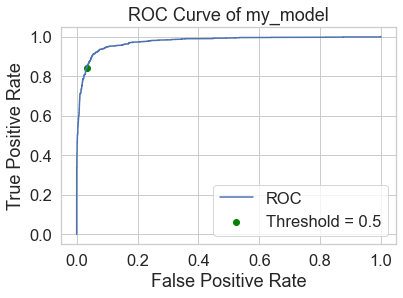

In [66]:
from sklearn.metrics import roc_curve

y_true = my_Y_train
y_score_arr = my_model.predict_proba(my_X_train)
# y_score_arr has probability of ham in column 1, and probability of spam in column 2
y_score = [row[1] for row in y_score_arr]
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)


# Where on this curve is threshold=0.5?
my_Y_pred = my_model.predict(my_X_train)

half_fp = sum((my_Y_pred != my_Y_train) & (my_Y_pred == 1))
half_tn = sum((my_Y_pred == my_Y_train) & (my_Y_pred == 0))
half_fpr = half_fp/(half_fp + half_tn)

half_tp = sum((my_Y_pred == my_Y_train) & (my_Y_pred == 1))
half_fn = sum((my_Y_pred != my_Y_train) & (my_Y_pred == 0))
half_tpr = half_tp/(half_tp + half_fn)



plt.plot(fpr, tpr, label='ROC')
plt.scatter([half_fpr], [half_tpr], color = 'green', label='Threshold = 0.5')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of my_model')
plt.legend()
